In [3]:
import math
import os.path
from os import listdir, path
from os.path import isfile, join
import datetime
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot


from pyapnea.oscar.oscar_loader import load_session
from pyapnea.oscar.oscar_getter import event_data_to_dataframe, get_channel_from_code
from pyapnea.oscar.oscar_constants import CHANNELS, ChannelID

In [4]:
# init notebook parameters
init_notebook_mode(connected=True)
#pd.set_option('display.max_rows', None)

In [6]:
data_path_cpap1 = 'C:/Users/wayne/OneDrive/Documents/Home/Health/Oscar_Data/Profiles/Wayne Gault/ResMed_23192575079/Events'
list_files = [{'label': f, 'value': f, 'fullpath': join(data_path_cpap1, f)} for f in listdir(data_path_cpap1) if isfile(join(data_path_cpap1, f))]



In [7]:
def event_data_to_dataframe_all_channel(oscar_session_data):
    possible_channels = [ChannelID.CPAP_FlowRate.value, ChannelID.CPAP_ClearAirway.value, ChannelID.CPAP_Obstructive.value, ChannelID.CPAP_Pressure.value]
    global_df = event_data_to_dataframe(oscar_session_data, possible_channels)
    global_df['local_time'] = global_df['time_utc'].dt.tz_convert('America/Montreal')
    global_df.sort_index(inplace=True)
    return global_df

# Displaying one session and the first event

In [9]:
# reading files
# number 2 has obstructive events
filename_to_load =  'C:/Users/wayne/OneDrive/Documents/Home/Health/Oscar_Data/Profiles/Wayne Gault/ResMed_23192575079/Events/65fcbe48.001'

oscar_session_data = load_session(filename_to_load)
df = event_data_to_dataframe_all_channel(oscar_session_data)

# TODO handle Leak two value per time
#df_Leak = event_data_to_dataframe(oscar_session_data, ChannelID.CPAP_Leak.value)
#np.where(df.index.duplicated(keep=False) == True)

display(df)


,time_utc,Pressure,FlowRate,Obstructive,local_time
0,2024-03-21 23:11:10+00:00,9.00,43.920002,NaN,2024-03-21 19:11:10-04:00
1,2024-03-21 23:25:52+00:00,9.00,-51.360002,10.0,2024-03-21 19:25:52-04:00
2,2024-03-21 23:25:52+00:00,9.62,-51.360002,10.0,2024-03-21 19:25:52-04:00
3,2024-03-21 23:25:54+00:00,9.62,45.360002,NaN,2024-03-21 19:25:54-04:00
4,2024-03-21 23:25:54+00:00,9.66,45.360002,NaN,2024-03-21 19:25:54-04:00
...,...,...,...,...,...
743475,2024-03-22 07:25:58.800000+00:00,NaN,20.880001,NaN,2024-03-22 03:25:58.800000-04:00
743476,2024-03-22 07:25:58.840000+00:00,NaN,20.040001,NaN,2024-03-22 03:25:58.840000-04:00
743477,2024-03-22 07:25:58.880000+00:00,NaN,19.200001,NaN,2024-03-22 03:25:58.880000-04:00
743478,2024-03-22 07:25:58.920000+00:00,NaN,18.000001,NaN,2024-03-22 03:25:58.920000-04:00


In [10]:
# reorganize dataframe to seaborn imput format
dfc = df[['FlowRate', 'Obstructive', 'Pressure', 'local_time']]
dfm = dfc.melt('local_time', var_name='cols', value_name='vals')
dfm.sort_values(by=['local_time'], inplace=True, ignore_index=True)
dfm_annotation = dfm[(~pd.isnull(dfm['vals']) & ((dfm['cols']=='Obstructive') | (dfm['cols']=='ClearAirway')))]
display(dfm_annotation)

,local_time,cols,vals
66976,2024-03-21 19:25:52-04:00,Obstructive,10.0
66977,2024-03-21 19:25:52-04:00,Obstructive,10.0
492298,2024-03-21 21:00:17.480000-04:00,Obstructive,10.0
954191,2024-03-21 22:42:49.480000-04:00,Obstructive,14.0
1311853,2024-03-22 00:02:11.760000-04:00,Obstructive,10.0
1386516,2024-03-22 00:18:45.240000-04:00,Obstructive,9.0
1539968,2024-03-22 00:52:48.840000-04:00,Obstructive,17.0
1545918,2024-03-22 00:54:07.960000-04:00,Obstructive,31.0
1586938,2024-03-22 01:03:13.800000-04:00,Obstructive,12.0
2185112,2024-03-22 03:15:55.720000-04:00,Obstructive,6.0


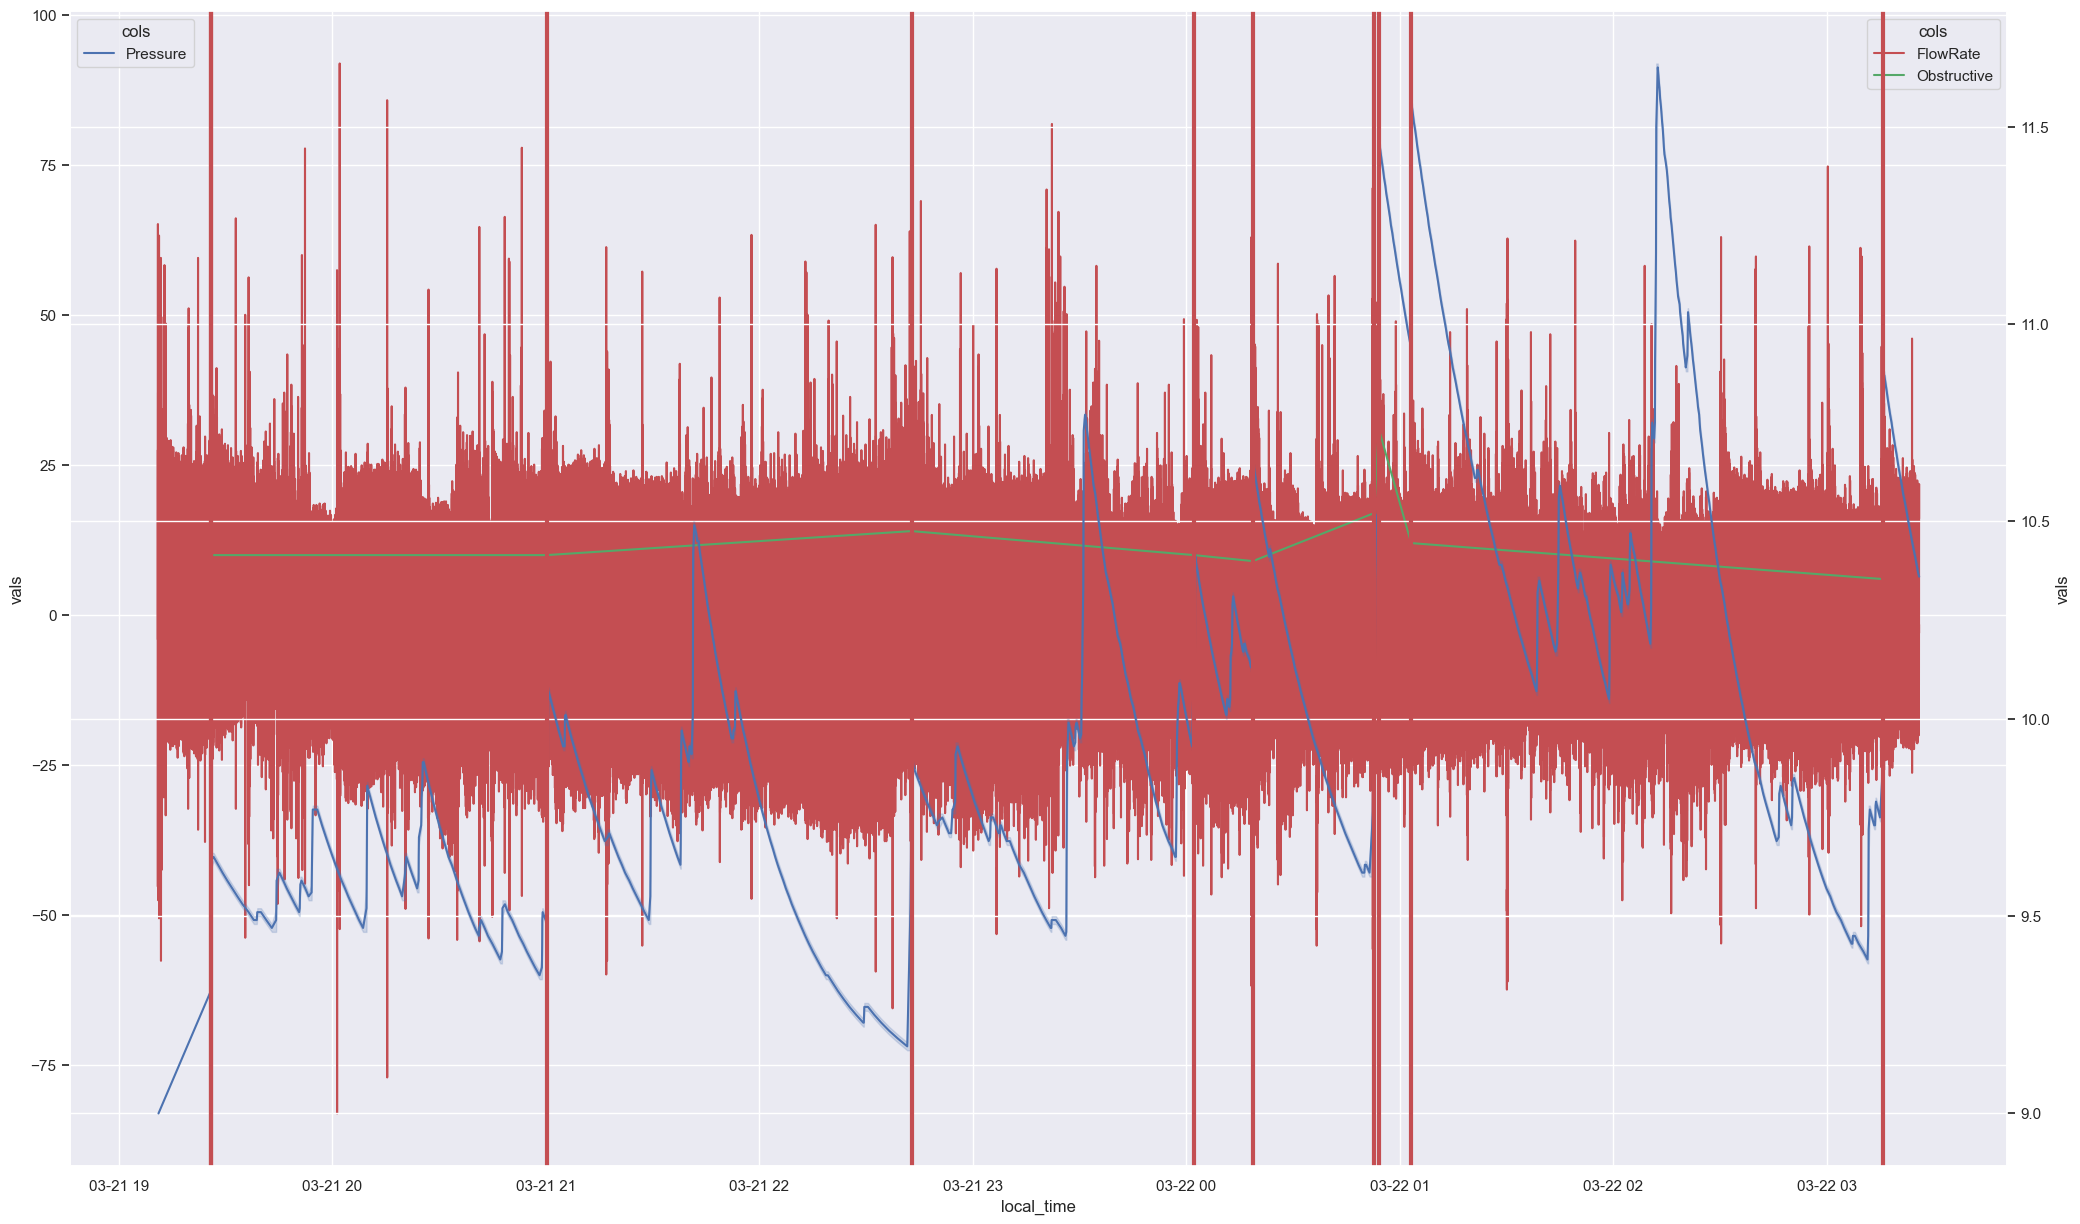

In [11]:
sns.set(rc={'figure.figsize':(25,15)})
fig, ax = plt.subplots()
sns.lineplot(data=dfm[dfm['cols']!='Pressure'],x='local_time', y='vals', hue='cols', palette=['r', 'g'], ax= ax)
ax2 = ax.twinx()
# warning : should not interpolate between points...
sns.lineplot(data=dfm[dfm['cols']=='Pressure'],x='local_time', y='vals', hue='cols', palette=['b'], ax = ax2)
for a in dfm_annotation['local_time']:
    plt.axvline(x=a, color='r', linewidth=3)

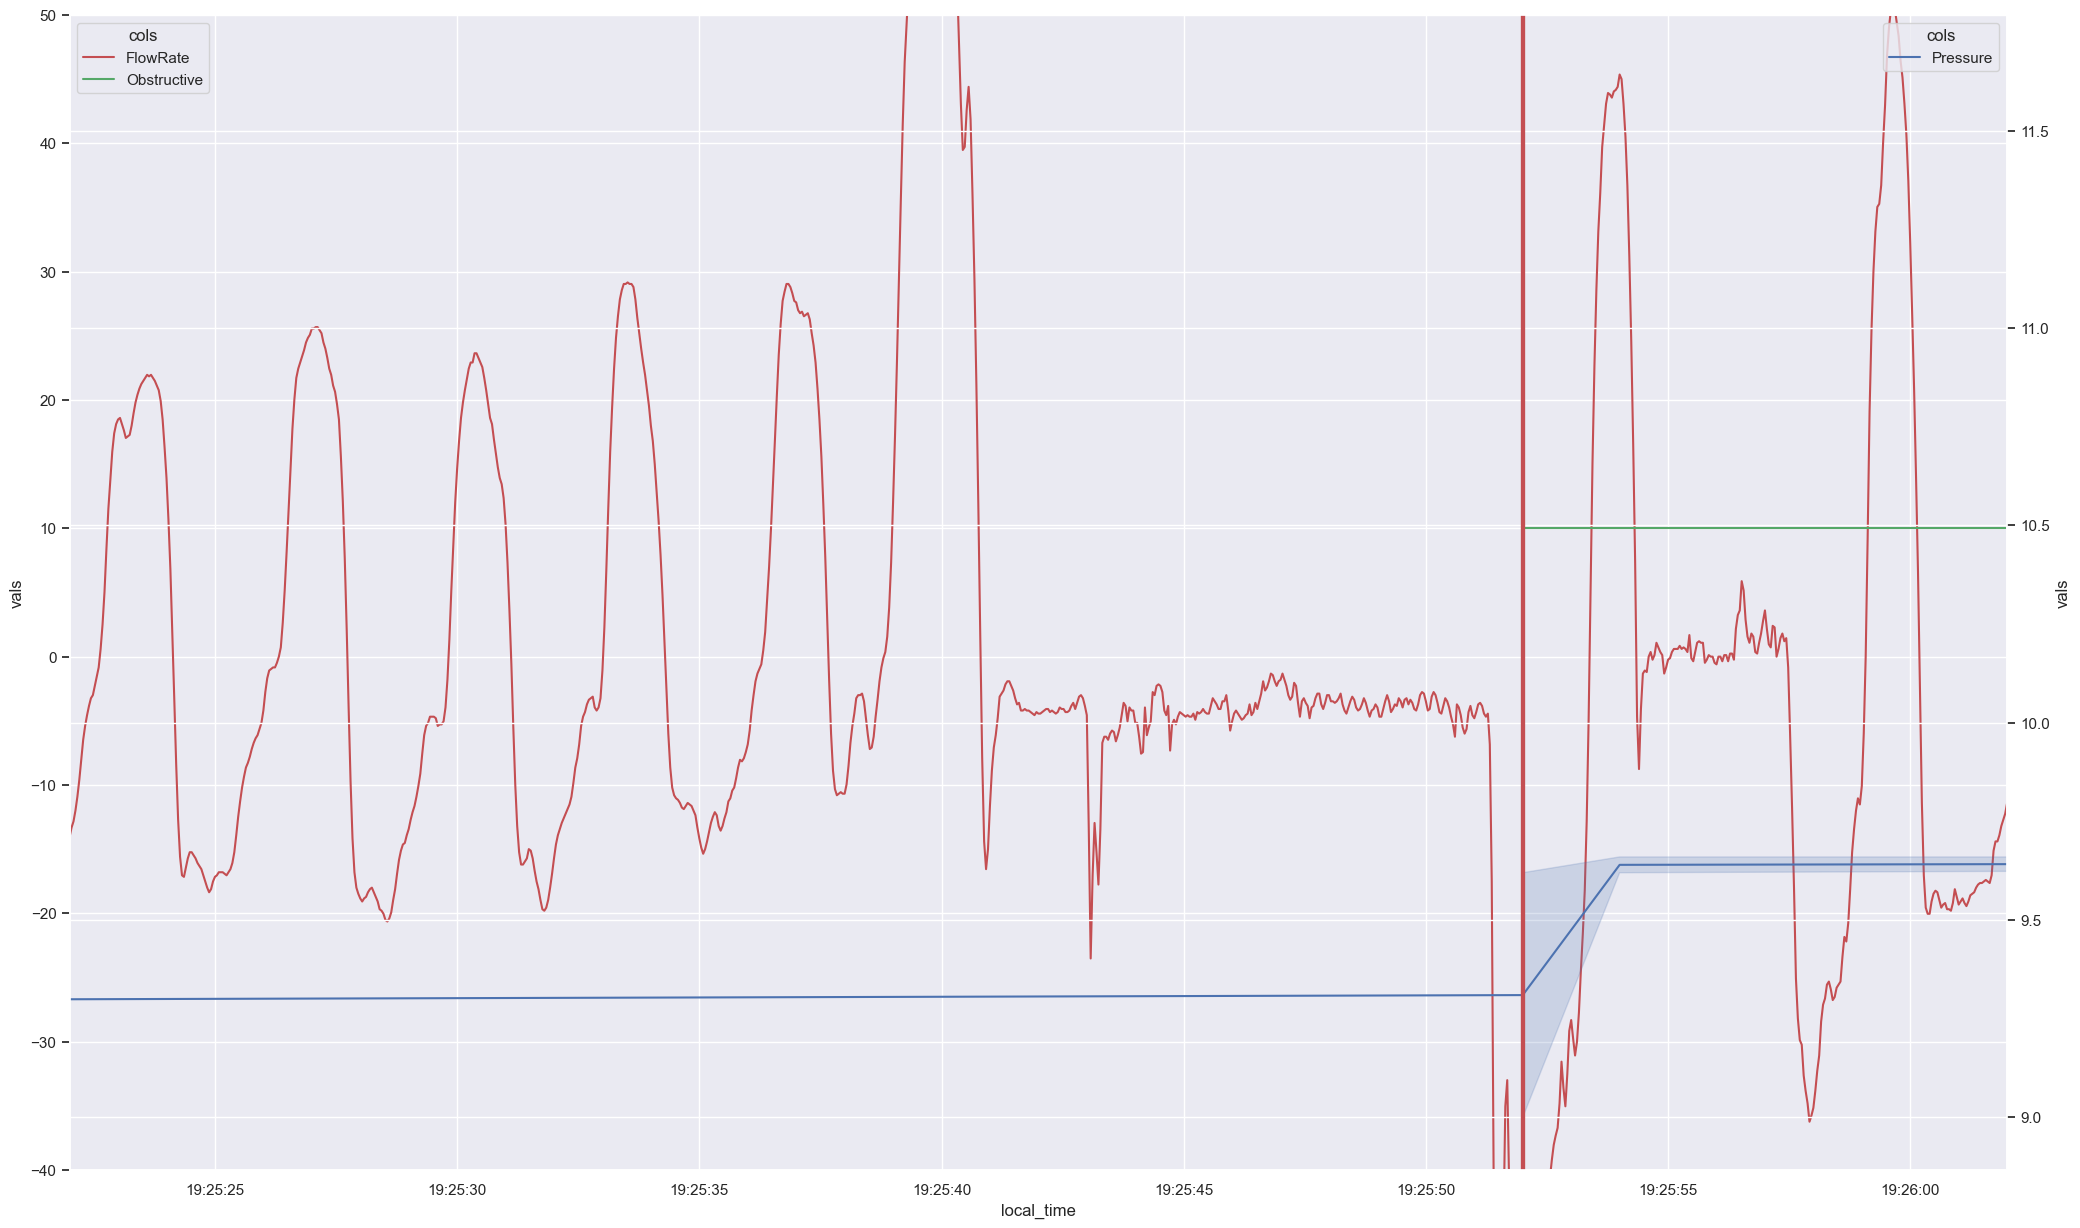

In [12]:
event_time = dfm_annotation['local_time'].iloc[0]
sns.set(rc={'figure.figsize':(25,15)})
fig, ax = plt.subplots()

ax.set_ylim(-40, 50)
ax.set_xlim(event_time - datetime.timedelta(seconds=30), event_time + datetime.timedelta(seconds=10))
sns.lineplot(data=dfm[dfm['cols']!='Pressure'],x='local_time', y='vals', hue='cols', palette=['r', 'g'], ax = ax)
ax2 = ax.twinx()
# warning : should not interpolate between points...
sns.lineplot(data=dfm[dfm['cols']=='Pressure'],x='local_time', y='vals', hue='cols', palette=['b'], ax = ax2)
for a in dfm_annotation['local_time']:
    plt.axvline(x=a, color='r', linewidth=3)

# Statistics
- Number of sessions
- Lenght of sessions

In [16]:
events_channels = [ChannelID.CPAP_ClearAirway.value,
                   ChannelID.CPAP_Obstructive.value,
                   ChannelID.CPAP_Hypopnea.value,
                   ChannelID.CPAP_Apnea.value, # ClearAway or Obstructive, not determined
                   ]
event_names = [[c[5] for c in CHANNELS if c[1].value == e][0] for e in events_channels]
event_names

['ClearAirway', 'Obstructive', 'Hypopnea', 'Apnea']

In [17]:
stats = dict()
stats['nb_sessions'] = len(list_files)
stats['sessions'] = []

df_event_all_sessions = None

#loading all files
with tqdm(total=len(list_files)) as pbar:
    for f in list_files:
        oscar_session_data = load_session(f['fullpath'])
        # FlowRate
        flowrate_chanel = get_channel_from_code(oscar_session_data, ChannelID.CPAP_FlowRate.value)
        flowrate_event = flowrate_chanel.events[0]

        stat_session = {'filename': f['label'],
                        'nb channel': len(oscar_session_data.data.channels),
                        'ts1' : flowrate_event.ts1,
                        'ts2' : flowrate_event.ts2,
                        'starting time' : datetime.datetime.fromtimestamp(flowrate_event.ts1/1000.0),
                        'lenght FlowRate (ms)': flowrate_event.ts2 - flowrate_event.ts1,
                        'FlowRate present': (ChannelID.CPAP_FlowRate.value in [c.code for c in oscar_session_data.data.channels])}

        # Events - TODO Refactor with event_data_to_dataframe with event_channels as parameter
        stat_session['events'] = []
        for e in events_channels:
            event_name = [c[5] for c in CHANNELS if c[1].value == e][0]
            event_channel_df = event_data_to_dataframe(oscar_session_data, [e])
            if not event_channel_df.empty:
                df_event = event_channel_df[~pd.isnull(event_channel_df[event_name])]
                df_event['type']  = event_name
                df_event['session'] = f['value']
            else:
                df_event = pd.DataFrame(data=[[np.NAN, event_name, f['value']]], columns=['time_utc', 'type', 'session'])
            if df_event_all_sessions is None:
                df_event_all_sessions = df_event[['time_utc', 'type', 'session']]
            else:
                df_event_all_sessions = pd.concat([df_event_all_sessions,  df_event[['time_utc', 'type', 'session']]])
        stats['sessions'].append(stat_session)
        pbar.update(1)
        oscar_session_data = None
# All event per session
print(df_event_all_sessions)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
# stats for event
# number of event per type
df_count_per_type = df_event_all_sessions.groupby(['type'])['time_utc'].count().to_frame(name = 'count').reset_index().sort_values('type')
# number of event per type per session
df_count_per_type_per_session = df_event_all_sessions.groupby(['session', 'type'])['time_utc'].count().to_frame(name = 'count').reset_index().sort_values('type')
print(df_count_per_type)
print(df_count_per_type_per_session)

In [ ]:
stats

In [ ]:
def ms_to_hour_min_sec_ms(ms):
    sec, ms = divmod(ms, 1000)
    min, sec = divmod(sec, 60)
    hour, min = divmod(min, 60)
    return hour, min, sec, ms

In [ ]:
import statistics as stat
import math
# FlowRate
length_array = np.array([s['lenght FlowRate (ms)'] for s in stats['sessions']])
sum_len = length_array.sum()
avg_len = length_array.mean()
med_len = np.median(length_array)
stddev_len = stat.stdev(length_array.tolist())
stats['FlowRate total length (ms)'] = sum_len
stats['FlowRate average length (ms)'] = avg_len
stats['FlowRate stddev (ms)'] = stddev_len
stats['FlowRate median (ms)'] = med_len
stats['FlowRate total length (hmsms)'] = ms_to_hour_min_sec_ms(sum_len)
stats['FlowRate average length (hmsms))'] = ms_to_hour_min_sec_ms(avg_len)
stats['FlowRate stddev (hmsms)'] = ms_to_hour_min_sec_ms(stddev_len)
stats['FlowRate median (hmsms)'] = ms_to_hour_min_sec_ms(med_len)

# Events
stats['events'] = {'count': pd.Series(df_count_per_type['count'].values,index=df_count_per_type['type']).to_dict()}
stats['events']['average_sess'] = {e: df_count_per_type_per_session[df_count_per_type_per_session['type']==e].mean(numeric_only=True).to_list()[0] for e in event_names}
stats['events']['stddev_sess'] = {e: stat.stdev(df_count_per_type_per_session[df_count_per_type_per_session['type']==e]['count']) for e in event_names}
stats['events']['median'] = {e: stat.median(df_count_per_type_per_session[df_count_per_type_per_session['type']==e]['count']) for e in event_names}

In [ ]:
stats

# Length

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
sns.boxplot(data=length_array/1000.0/60/60).set(xlabel='Sessions', ylabel='Length (hour)')

In [ ]:

sns.set(rc={'figure.figsize':(25,5)})
length_dict = np.array([{'length': s['lenght FlowRate (ms)']/1000.0/60/60, 'start': s['starting time']} for s in stats['sessions']])
df_length_session = pd.DataFrame.from_records(length_dict).sort_values(by='start')
sns.scatterplot(data=df_length_session, x='start', y='length').set(xlabel='Date', ylabel='Length (hour)')

# Events

In [ ]:
# nb event per session (average + stddev)
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(data=df_count_per_type_per_session, x='type', y='count', errorbar='sd').set(xlabel='type of event', ylabel='Nb events per session (avg+stdev)')

In [ ]:
# nb event per session (average + stderr)
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(data=df_count_per_type_per_session, x='type', y='count', errorbar='se').set(xlabel='type of event', ylabel='Nb events per session (avg+stderr)')

In [ ]:
sns.boxplot(data=df_count_per_type_per_session, x='type', y='count')/1000.0/60/60

In [ ]:
# nb event per type
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(data=df_count_per_type, x='type', y='count').set(xlabel='type of event', ylabel='Nb events per type')